## 1. Volatility changes over time
<p>What is financial risk? </p>
<p>Financial risk has many faces, and we measure it in many ways, but for now, let's agree that it is a measure of the possible loss on an investment. In financial markets, where we measure prices frequently, volatility (which is analogous to <em>standard deviation</em>) is an obvious choice to measure risk. But in real markets, volatility changes with the market itself. </p>
<p><img src="https://assets.datacamp.com/production/project_738/img/VolaClusteringAssetClasses.png" alt></p>
<p>In the picture above, we see the returns of four very different assets. All of them exhibit alternating regimes of low and high volatilities. The highest volatility is observed around the end of 2008 - the most severe period of the recent financial crisis.</p>
<p>In this notebook, we will build a model to study the nature of volatility in the case of US government bond yields.</p>

In [34]:
# Load the packages
library(zoo)
library(xts)
library(readr)
library(viridisLite)
library(rugarch)
# .... YOUR CODE FOR TASK 1 ....

# Load the data
yc_raw <- read_csv("datasets/FED-SVENY.csv")

# Convert the data into xts format
yc_all <- as.xts(x = yc_raw[, -1], order.by = yc_raw$Date)

# Show only the tail of the 1st, 5th, 10th, 20th and 30th columns
yc_all_tail <- tail(yc_all[, c(1, 5, 10, 20, 30)])
print(yc_all_tail)

Parsed with column specification:
cols(
  .default = col_double(),
  Date = col_date(format = "")
)
See spec(...) for full column specifications.


           SVENY01 SVENY05 SVENY10 SVENY20 SVENY30
2019-03-22  2.4222  2.2613  2.4553  2.7661  3.0178
2019-03-25  2.3901  2.2281  2.4449  2.7610  3.0216
2019-03-26  2.3811  2.2016  2.4249  2.7508  3.0138
2019-03-27  2.3560  2.1931  2.4020  2.7092  2.9785
2019-03-28  2.3601  2.2137  2.4058  2.6907  2.9605
2019-03-29  2.3719  2.2398  2.4143  2.6939  2.9538


In [18]:
# These packages need to be loaded in the first @tests cell
library(testthat) 
library(IRkernel.testthat)

soln_yc_raw <- read_csv("datasets/FED-SVENY.csv")
soln_yc_all <- as.xts(x = soln_yc_raw[, -1], order.by = soln_yc_raw$Date)

soln_yc_all_tail <- tail(soln_yc_all[, c(1, 5, 10, 20, 30)])
 
run_tests({
    # Packages loaded
    test_that("the correct package is loaded", {
        expect_true("xts" %in% .packages(), 
                    info = "Did you load the xts package?")
        expect_true("readr" %in% .packages(), 
                    info = "Did you load the readr package?")
    })
    
    # Date set loaded
    test_that("the dataset is loaded correctly", {
        expect_is(yc_raw, "tbl_df", info = "Did you read in the data with read_csv() (not read.csv() )?")
        expect_equal(yc_raw, soln_yc_raw, 
                     info = "yc_raw contains the wrong values. Did you import the CSV file correctly?")
    })
    
    test_that("the xts object is created correctly", {
        expect_equal(yc_all, soln_yc_all, 
                     info = "yc_all contains the wrong values. At the conversion, did you filter out the first column? Did you apply the date column as index?")
    })
    
    # Output shown
    test_that("output shown", {
                expect_equal(yc_all_tail, soln_yc_all_tail, 
                    info = "The output shown is not correct. Did you choose the correct columns? Did you use tail()?")
    })
})


Parsed with column specification:
cols(
  .default = col_double(),
  Date = col_date(format = "")
)
See spec(...) for full column specifications.


4/4 tests passed

## 2. Plotting the evolution of bond yields
<p>In the output table of the previous task, we see the yields for some maturities.</p>
<p>These data include the whole yield curve. The yield of a bond is the price of the money lent. The higher the yield, the more money you receive on your investment. The yield curve has many maturities; in this case, it ranges from 1 year to 30 years. Different maturities have different yields, but yields of neighboring maturities are relatively close to each other and also move together.</p>
<p>Let's visualize the yields over time. We will see that the long yields (e.g. SVENY30) tend to be more stable in the long term, while the short yields (e.g. SVENY01) vary a lot. These movements are related to the monetary policy of the FED and economic cycles.</p>

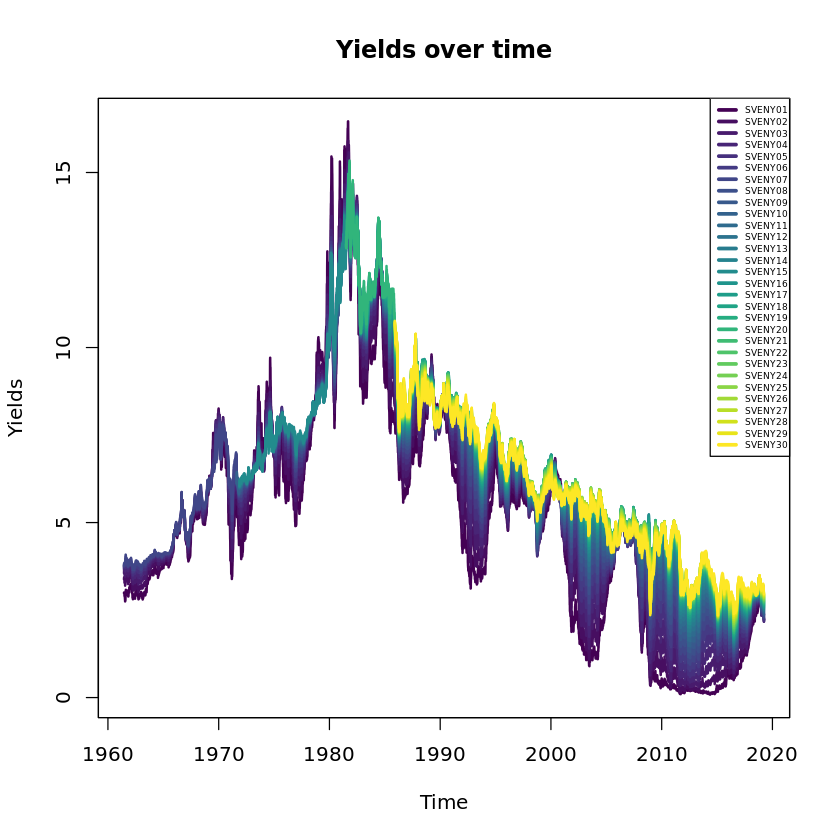

In [35]:
# Define plot arguments
yields <- yc_all
plot.type <- "single"
plot.palette <- viridis(30)
asset.names <- colnames(yc_all)

# Plot the time series
plot.zoo( x = yc_all, plot.type = plot.type, col = plot.palette, 
         lwd = 2, xlab = "Time", ylab = "Yields", main = "Yields over time"
)

# Add the legend
legend(x = "topright",legend = asset.names, col = plot.palette, cex = 0.45, lwd = 3)


In [20]:
soln_yields  <- soln_yc_all
soln_plot.type  <- "single"
soln_plot.palette <- viridis(30)
soln_asset.names <- colnames(soln_yc_all)

run_tests({
    # Plot parameters
    test_that("plot parameters are correct", {
        expect_equal(soln_yields, yields, 
                     info = "The data are not correct. Check that you used yc_all.")
    })
    test_that("plot parameters are correct", {
        expect_equal(soln_plot.type, plot.type,
                    info = "Did you set the plot.type correctly? It can be either 'single' or 'mulitple'.")
    })
    test_that("plot parameters are correct", {
        expect_equal(soln_plot.palette, plot.palette,
                    info = "The color palette is not correct. Did you use 30 colors from viridis?")
    })
    test_that("the legend was correctly defined", {
        expect_equal(soln_asset.names, asset.names,
                    info = "The the legend was not correctly defined. It should be the vector of column names of yc_all.")
        })
    })

2/4 tests passed
> error :: plot parameters are correct
object 'yields' not found 
---
> fail :: plot parameters are correct
`soln_plot.type` not equal to `plot.type`.
1/1 mismatches
x[1]: "single"
y[1]: "multiple"
Did you set the plot.type correctly? It can be either 'single' or 'mulitple'.
Reason:  
---

## 3. Make the difference
<p>In the output of the previous task, we see the level of bond yields for some maturities, but to understand how volatility evolves we have to examine the changes in the time series. Currently, we have yield levels; we need to calculate the changes in the yield levels. This is called "differentiation" in time series analysis. Differentiation has the added benefit of making a time series independent of time.</p>

In [36]:
# Differentiate the time series  
ycc_all <- diff.xts(yc_all)

# Show the tail of the 1st, 5th, 10th, 20th and 30th columns
ycc_all_tail <- tail(ycc_all[,c(1,5,10,20,30)])
print(ycc_all_tail) 

           SVENY01 SVENY05 SVENY10 SVENY20 SVENY30
2019-03-22 -0.0412 -0.1039 -0.0878 -0.0924 -0.0864
2019-03-25 -0.0321 -0.0332 -0.0104 -0.0051  0.0038
2019-03-26 -0.0090 -0.0265 -0.0200 -0.0102 -0.0078
2019-03-27 -0.0251 -0.0085 -0.0229 -0.0416 -0.0353
2019-03-28  0.0041  0.0206  0.0038 -0.0185 -0.0180
2019-03-29  0.0118  0.0261  0.0085  0.0032 -0.0067


In [22]:
soln_ycc_all <- diff.xts(soln_yc_all)

# Show only the 1st, 5th, 10th, 20th and 30th columns
soln_ycc_all_tail <- tail(soln_ycc_all[, c(1, 5, 10, 20, 30)])


run_tests({
    # Differentiation is correct
    test_that("ycc_all is correct", {
        expect_equal(ycc_all, soln_ycc_all,
                    info = "You did not differentiate the time series correctly. Did you use the diff.xts() function on yc_all?"
                    )
    })
    
     # Output shown
    test_that("output shown", {
                expect_equal(ycc_all_tail, soln_ycc_all_tail, 
                    info = "The output shown is not correct. Did you choose the correct columns? Did you use tail()?" )
    })
})

2/2 tests passed

## 4. The US yields are no exceptions, but maturity matters
<p>Now that we have a time series of the changes in US government yields let's examine it visually.</p>
<p>By taking a look at the time series from the previous plots, we see hints that the returns following each other have some unique properties:</p>
<ul>
<li>The direction (positive or negative) of a return is mostly independent of the previous day's return. In other words, you don't know if the next day's return will be positive or negative just by looking at the time series.</li>
<li>The magnitude of the return is similar to the previous day's return. That means, if markets are calm today, we expect the same tomorrow. However, in a volatile market (crisis), you should expect a similarly turbulent tomorrow.</li>
</ul>

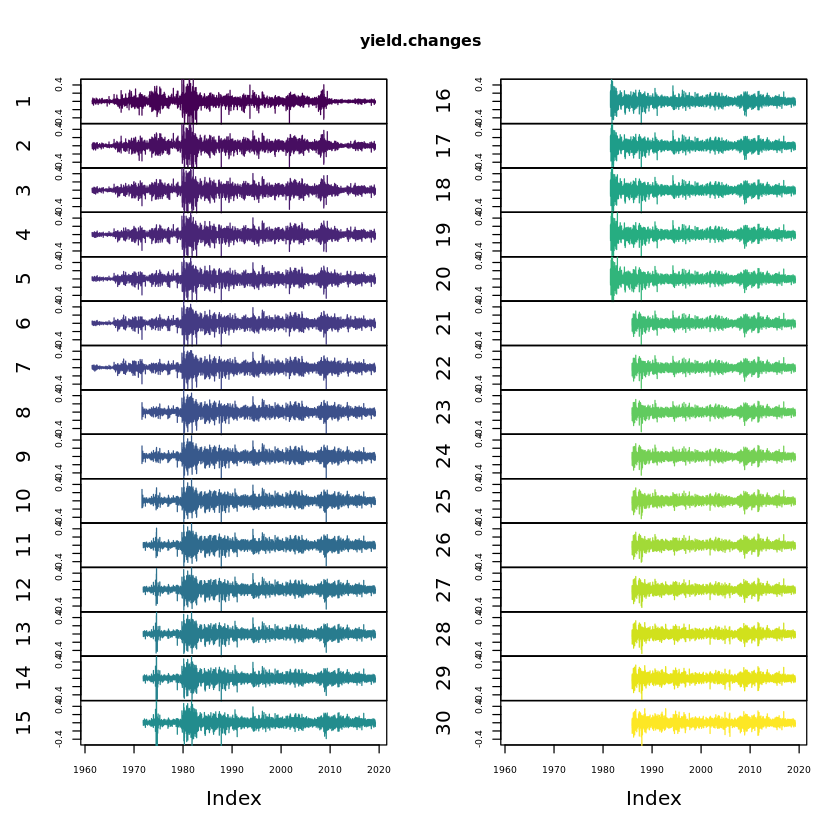

In [37]:
# Define the plot parameters
yield.changes <- ycc_all
plot.type <- "multiple"

# Plot the differentiated time series
plot.zoo(x = yield.changes, plot.type = plot.type, 
         ylim = c(-0.5, 0.5), cex.axis = 0.7, 
         ylab = 1:30, col = plot.palette)

In [24]:
# One or more tests of the student's code
# The @solution should pass the tests
# The purpose of the tests is to try to catch common errors and
# to give the student a hint on how to resolve these errors

soln_yield.changes <- soln_ycc_all
soln_plot.type <- "multiple"

run_tests({
    # Plot parameters
    test_that("the plotted data are correct", {
        expect_equal(soln_yield.changes, yield.changes, 
                     info = "Did you set the parameter x correctly? It should be the differentiated data.")
    })
    
    test_that("plot.type set correctly", {
        expect_equal(plot.type, soln_plot.type, 
                     info = "Did you set the plot.type correctly? It can be either 'single' or 'mulitple'.")
    })
})


2/2 tests passed

## 5. Let's dive into some statistics
<p>The statistical properties visualized earlier can be measured by analytical tools. The simplest method is to test for autocorrelation. Autocorrelation measures how a datapoint's past determines the future of a time series. </p>
<ul>
<li>If the autocorrelation is close to 1, the next day's value will be very close to today's value. </li>
<li>If the autocorrelation is close to 0, the next day's value will be unaffected by today's value.</li>
</ul>
<p>Because we are interested in the recent evolution of bond yields, we will filter the time series for data from 2000 onward.</p>

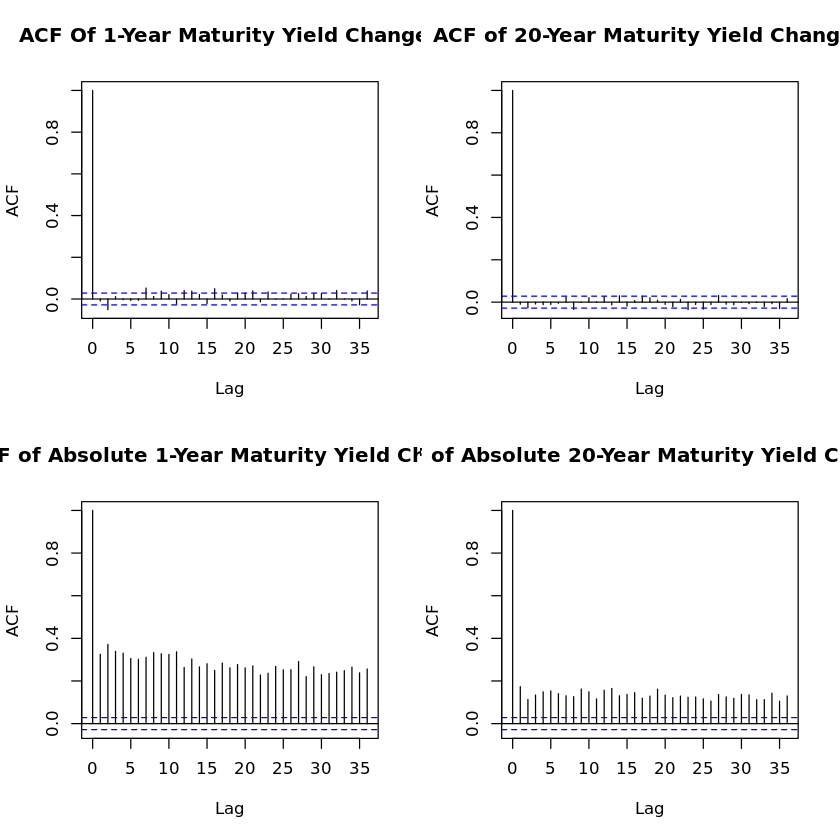

In [38]:
# Filter for changes in and after 2000
ycc <- ycc_all["2000/"]

# Save the 1-year and 20-year maturity yield changes into separate variables
x_1 <- ycc[,"SVENY01"]
x_20 <- ycc[,"SVENY20"]

# Plot the autocorrelations of the yield changes
par(mfrow=c(2,2))
acf_1 <- acf(x_1, main = "ACF Of 1-Year Maturity Yield Changes")
acf_20 <- acf(x_20, main = "ACF of 20-Year Maturity Yield Changes")

# Plot the autocorrelations of the absolute changes of yields
acf_abs_1 <- acf(abs(x_1), 
                 main = "ACF of Absolute 1-Year Maturity Yield Changes")
acf_abs_20 <- acf(abs(x_20), 
                  main = "ACF of Absolute 20-Year Maturity Yield Changes")

In [26]:
# Filter for changes in and after 2000
soln_ycc <- soln_ycc_all["2000/", ]

# Save the 1-year and 20-year maturity yield changes into separate variables
soln_x_1 <- soln_ycc[, "SVENY01"]
soln_x_20 <- soln_ycc[, "SVENY20"]

# Plot the autocorrelations of the changes of yields
par(mfrow=c(2,2))
soln_acf_1 <- acf(soln_x_1, plot = FALSE)
soln_acf_20 <- acf(soln_x_20, plot = FALSE)
# Plot the autocorrelations of the absolute changes of yields, too
soln_acf_abs_1 <- acf(abs(soln_x_1), plot = FALSE)
soln_acf_abs_20 <- acf(abs(soln_x_20), plot = FALSE)



run_tests({
    test_that("ycc is correct", {
        expect_equal(ycc, soln_ycc,
                     info = "ycc is not correct. Did you filter for the time period in and after 2000 correctly?"
                    )        
    })
    test_that("x_1 is correct", {
        expect_equal(x_1, soln_x_1,
                     info = "x_1 is not correct. Did you select the 1st column?"
                    )        
    })
    test_that("x_20 is correct", {
        expect_equal(x_20, soln_x_20,
                     info = "x_20 is correct. Did you select the 20th column?"
                    )        
    })    
    test_that("acf_1 is correct", {
        expect_equal(acf_1$acf, soln_acf_1$acf,
                     info = "Autocorrelation of x_1 is not correct. Did you use the acf() function on x_1?"
                    )        
    })
    
    test_that("acf_20` is correct", {
        expect_equal(acf_20$acf, soln_acf_20$acf,
                     info = "Autocorrelation of x_20 is not correct. Did you use the acf() function on x_20?"
                    )        
    })        
    test_that("acf_abs_1 is correct", {
        expect_equal(acf_abs_1$acf, soln_acf_abs_1$acf, label = "acf_abs_1", expected.label = "acf(abs(x_1))",
                     info = "Autocorrelation of absolute values of x_1 is not correct. Did you use the acf() and abs() functions on x_1?"
                    )        
    })
    test_that("acf_abs_20 is correct", {
        expect_equal(acf_abs_20$acf, soln_acf_abs_20$acf, label = "acf_abs_20", expected.label = "acf(abs(x_20))",
                     info = "Autocorrelation of absolute values of x_20 is not correct. Did you use the acf() and abs() functions on x_20?"
                    )        
    })
})

7/7 tests passed

## 6. GARCH in action
<p>A Generalized AutoRegressive Conditional Heteroskedasticity (<a href="https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity">GARCH</a>) model is the most well known econometric tool to handle changing volatility in financial time series data. It assumes a hidden volatility variable that has a long-run average it tries to return to while the short-run behavior is affected by the past returns.</p>
<p>The most popular form of the GARCH model assumes that the volatility follows this process:
</p><p></p>
<math>
    &sigma;<sup>2</sup><sub>t</sub> = &omega; + &alpha; ⋅ &epsilon;<sup>2</sup><sub>t-1</sub> + &beta; ⋅ &sigma;<sup>2</sup><sub>t-1</sub>
</math>
<p></p><p></p>
<math>        
where &sigma; is the current volatility, &sigma;<sub>t-1</sub> the last day's volatility and &epsilon;<sub>t-1</sub> is the last day's return. The estimated parameters are &omega;, &alpha;, and &beta;.
</math>
<p>For GARCH modeling we will use <a href="https://cran.r-project.org/web/packages/rugarch/index.html"><code>rugarch</code></a> package developed by Alexios Ghalanos.</p>

ERROR: Error in match.arg(x, c("bottomright", "bottom", "bottomleft", "left", : 'arg' should be one of "bottomright", "bottom", "bottomleft", "left", "topleft", "top", "topright", "right", "center"


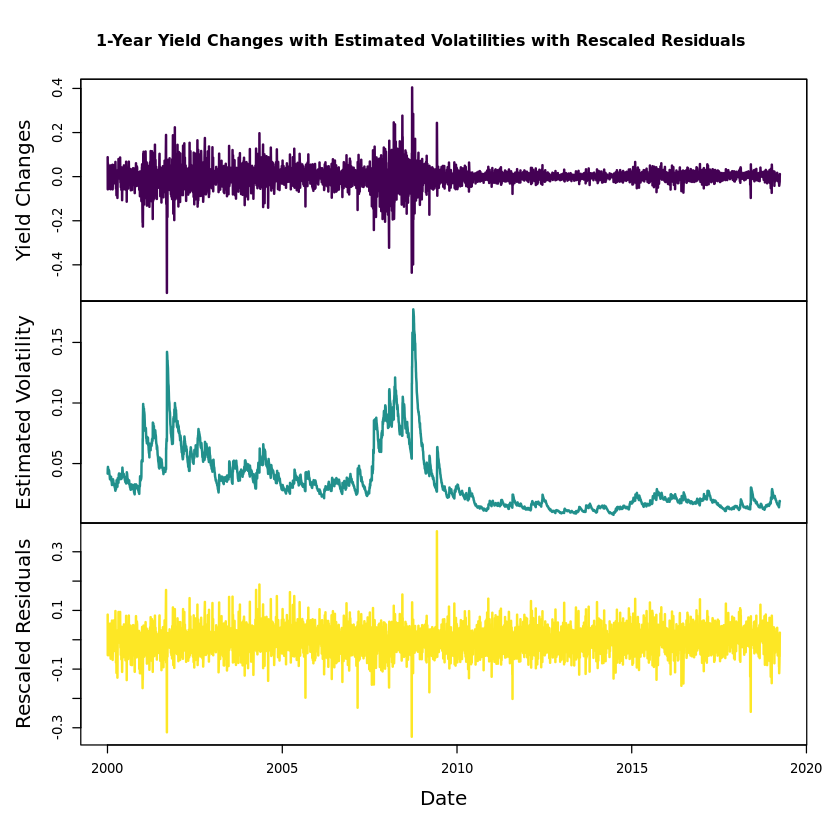

In [40]:
# Specify the GARCH model with the skewed t-distribution
spec <- ugarchspec(
    variance.model = list(model = "sGARCH", garchOrder = c(1,1)), 
    mean.model = list(armaOrder = c(0,0)),
    distribution.model = "sstd"
)

# Fit the model
fit_1 <- ugarchfit(data = x_1, spec = spec)

# Save the volatilities and the rescaled residuals
vol_1 <- sigma(fit_1)
res_1 <- scale(residuals(fit_1, standardize = TRUE)) * sd(x_1) + mean(x_1)

# Plot the yield changes with the estimated volatilities and residuals
merge_1 <- merge.xts(x_1, vol_1, res_1)
colnames(merge_1) <- c("Yield Changes", "Estimated Volatility", "Rescaled Residuals")

#Generate a palette of colours using viridis
plot_palette <- viridis(3)

#Plot the Yeild Changes with Estimated Volatilities and residuals
plot.zoo(merge_1, main = "1-Year Yield Changes with Estimated Volatilities with Rescaled Residuals",
        col = plot_palette, lwd = 2, xlab ="Date", ylab = colnames(merge_1))

#Adding a legend to the Plot
legend("Topright", legend = colnames(merge_1), col = plot_palette, lwd = 2, cex = 0.8)

In [ ]:
# Specify the GARCH model with the skewed t-distribution
soln_spec <- ugarchspec(distribution.model = "sstd")

# Fit the model
soln_fit_1 <- ugarchfit(soln_x_1, spec = soln_spec)

# Save the volatilities and the rescaled residuals
soln_vol_1 <- sigma(soln_fit_1)
soln_res_1 <- scale(residuals(soln_fit_1, standardize = TRUE)) * sd(soln_x_1) + mean(soln_x_1)

# Plot the yield changes with the estimated volatilities and residuals.
soln_merge_1 <- merge.xts(soln_x_1, vol_1 = soln_vol_1, res_1 = soln_res_1)

run_tests({
    test_that("spec is correct", {
        expect_equal(spec, soln_spec, 
            info = "The ugarch specification is not correct. Did you use the ugarchspec() function and the 'sstd' parameter?"
        )
    })
    
    test_that("fit_1 is correct", {
        expect_equal(fit_1@fit$residuals, soln_fit_1@fit$residuals, 
            info = "The fitted model is not correct. Did you apply the ugarchfit() function on x_1 with specification defined earlier?"
        )
    })
    
    test_that("vol_1 is correct", {
        expect_equal(vol_1, soln_vol_1, 
            info = "The volatility is not correct. Did you use the sigma() function on the fitted model (fit_1?"
        )
    })
    
    test_that("res_1 is correct", {
        expect_equal(res_1, soln_res_1, 
            info = "The residuals are not correct. Did you use the residuals() function on the fitted model (fit_1? The standardize parameter can be either TRUE or FALSE."
        )
    })
    
    test_that("merge_1 is correct", {
        expect_equal(merge_1, soln_merge_1, 
            info = "The merged object is not correct. Did you applied the merge.xts() function on the original series (x_1), the volatilities (vol_1) and the residuals (res_1)?"
        )
    })
})

## 7. Fitting the 20-year maturity
<p>Let's do the same for the 20-year maturity. As we can see in the plot from Task 6, the bond yields of various maturities show similar but slightly different characteristics. These different characteristics can be the result of multiple factors such as the monetary policy of the FED or the fact that the investors might be different.</p>
<p>Are there differences between the 1-year maturity and 20-year maturity plots?</p>

ERROR: Error in match.arg(x, c("bottomright", "bottom", "bottomleft", "left", : 'arg' should be one of "bottomright", "bottom", "bottomleft", "left", "topleft", "top", "topright", "right", "center"


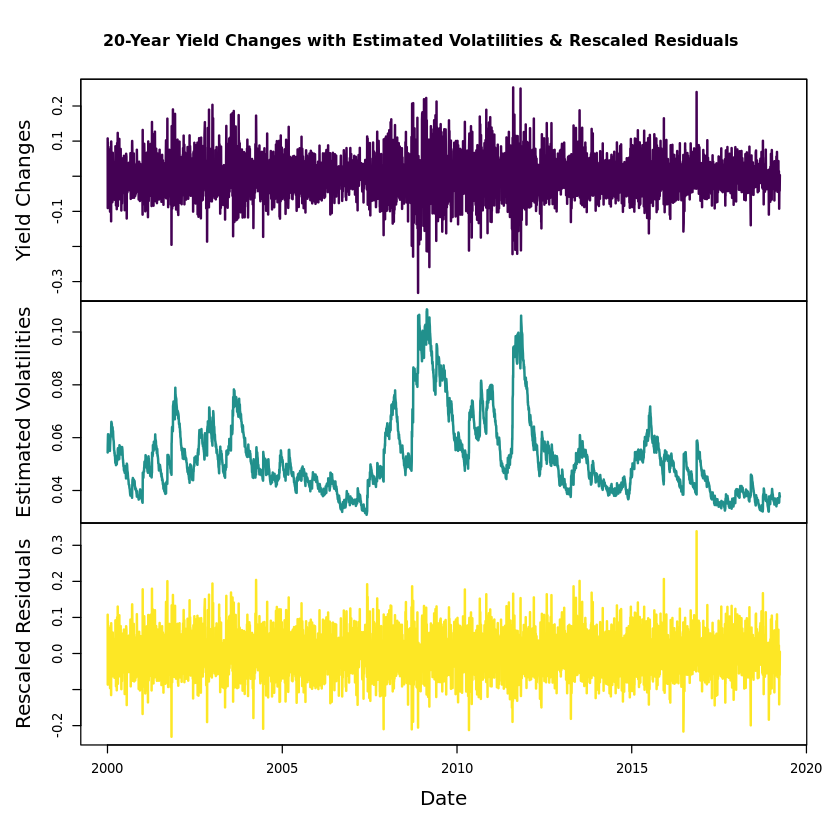

In [41]:
# Fit the model
fit_20 <- ugarchfit(data = x_20, spec = spec)

# Save the volatilities and the rescaled residuals
vol_20 <- sigma(fit_20)
res_20 <- scale(residuals(fit_20, standardize = TRUE)) * sd(x_20) + mean(x_20)

# Plot the yield changes with the estimated volatilities and residuals
merge_20 <- merge.xts(x_20, vol_20, res_20)
colnames(merge_20) <- c("Yield Changes", "Estimated Volatilities", "Rescaled Residuals")

#Generate a Palette of colours using viridis
plot_palette = viridis(3)

#Plot the Yield Changes with Estimated Volatilities with Rescaled Residuals
plot.zoo(merge_20, main = "20-Year Yield Changes with Estimated Volatilities & Rescaled Residuals", 
        col = plot_palette, lwd = 2, xlab = "Date", ylab = colnames(merge_20))

#Legend 
legend("Topright", legend = colnames(merge_20), col = plot_palette, lwd = 2, cex = 0.8)

In [ ]:
# Specify the GARCH model with the skewed t-distribution
soln_spec <- ugarchspec(distribution.model = "sstd")

# Fit the model
soln_fit_20 <- ugarchfit(soln_x_20, spec = soln_spec)

# Save the volatilities and the rescaled residuals
soln_vol_20 <- sigma(soln_fit_20)
soln_res_20 <- scale(residuals(soln_fit_20, standardize = TRUE)) * sd(soln_x_20) + mean(soln_x_20)

# Plot the yield changes with the estimated volatilities and residuals.
soln_merge_20 <- merge.xts(soln_x_20, vol_20 = soln_vol_20, res_20 = soln_res_20)


run_tests({
    test_that("spec is correct", {
        expect_equal(spec, soln_spec, 
            info = "The ugarch specification is not correct. Did you use the ugarchspec() function and the 'sstd' parameter?"
        )
    })
    
    test_that("fit_20 is correct", {
        expect_equal(fit_20@fit$residuals, soln_fit_20@fit$residuals, 
            info = "The fitted model is not correct. Did you apply the ugarchfit() function on x_20 with specification defined earlier?"
        )
    })
    
    test_that("vol_20 is correct", {
        expect_equal(vol_20, soln_vol_20, 
            info = "The volatility is not correct. Did you use the sigma() function on the fitted model (fit_20)?"
        )
    })
    
    test_that("res_20 is correct", {
        expect_equal(res_20, soln_res_20, 
            info = "The residuals are not correct. Did you use the residuals() function on the fitted model (fit_20? The standardize parameter can be either TRUE or FALSE."
        )
    })
    
    test_that("merge_20 is correct", {
        expect_equal(merge_20, soln_merge_20, 
            info = "The merged object is not correct. Did you applied the merge.xts() function on the original series (x_20), the volatilities (vol_20) and the residuals (res_20)?"
        )
    })
})

## 8. What about the distributions? (Part 1)
<p>From the plots in Task 6 and Task 7, we can see that the 1-year GARCH model shows a similar but more erratic behavior compared to the 20-year GARCH model. Not only does the 1-year model have greater volatility, but the volatility of its volatility is larger than the 20-year model. That brings us to two statistical facts of financial markets not mentioned yet. </p>
<ul>
<li>The unconditional (before GARCH) distribution of the yield differences has heavier tails than the normal distribution.</li>
<li>The distribution of the yield differences adjusted by the GARCH model has lighter tails than the unconditional distribution, but they are still heavier than the normal distribution.</li>
</ul>
<p>Let's find out what the fitted GARCH model did with the distribution we examined.</p>

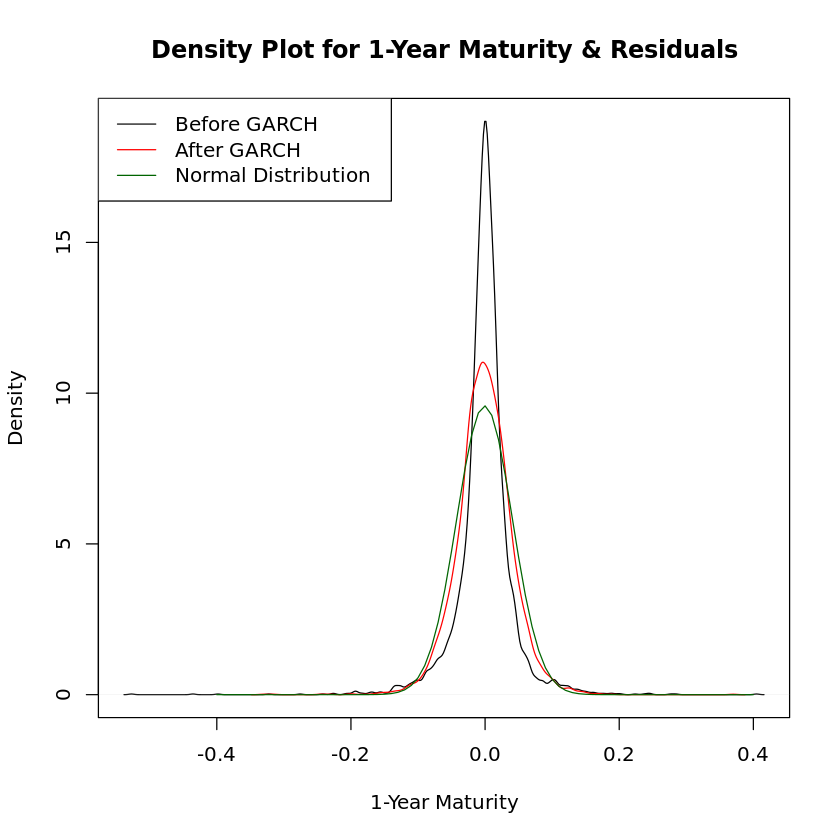

In [43]:
# Calculate the kernel density for the 1-year maturity and residuals
density_x_1 <- density(x_1)
density_res_1 <- density(res_1)

# Plot the density diagram for the 1-year maturity and residuals
plot(density_x_1, main ="Density Plot for 1-Year Maturity & Residuals", xlab = "1-Year Maturity", ylab = "Density")
lines(density_res_1, col = "red")

# Add the normal distribution to the plot
norm_dist <- dnorm(seq(-0.4, 0.4, by = .01), mean = mean(x_1), sd = sd(x_1))
lines(seq(-0.4, 0.4, by = .01), norm_dist, col = "darkgreen")

# Add legend
legend_labels <- c("Before GARCH", "After GARCH" , "Normal Distribution")
legend("topleft", legend = legend_labels, 
       col = c("black", "red", "darkgreen"), lty=c(1,1))

In [ ]:
# One or more tests of the student's code
# The @solution should pass the tests
# The purpose of the tests is to try to catch common errors and
# to give the student a hint on how to resolve these errors


# Plot the density diagram for 1-year maturity
soln_density_x_1 <- density(soln_x_1)

# Add the density of the residuals
soln_density_res_1 <- density(soln_res_1)


# And finally add the normal distribution to the plot
soln_norm_dist <- dnorm(seq(-0.4, 0.4, by = .01), mean = mean(soln_x_1), sd = sd(soln_x_1))

# Add legend
soln_legend <- c("Before GARCH", "After GARCH", "Normal distribution")


run_tests({
    test_that("density_x_1 is correct", {
        expect_equal(density_x_1$x, soln_density_x_1$x, 
            info = "Density of original time series is not correct. Did you apply the density() function on x_1?"
        )
        expect_equal(density_x_1$y, soln_density_x_1$y, 
            info = "Density of original time series is not correct. Did you apply the density() function on x_1?"
        )        
    })
    
    test_that("soln_res_1 is correct", {
        expect_equal(density_res_1$x, soln_density_res_1$x, 
            info = "Density of residuals is not correct. Did you apply the density() function on res_1?"
        )
        expect_equal(density_res_1$y, soln_density_res_1$y, 
            info = "Density of residuals is not correct. Did you apply the density() function on res_1?"
        )
    })
    
    test_that("normal distribution is correct", {
        expect_equal(norm_dist, soln_norm_dist, 
            info = "The normal distrubution in the plot is not correct. Did you define the mean and sd correctly?"
        )
    })  
    
    test_that("legend is correct", {
        expect_equal(legend, soln_legend, 
            info = "The legend is not correct. Did you listed the labels in the instructions correctly?"
        )
    })        
    
})


## 9. What about the distributions? (Part 2)
<p>In the previous plot, we see that the two distributions from the GARCH models are different from the normal distribution of the data, but the tails, where the differences are the most profound, are hard to see. Using a Q-Q plot will help us focus in on the tails.</p>
<p>You can read an excellent summary of Q-Q plots <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">here</a>.</p>

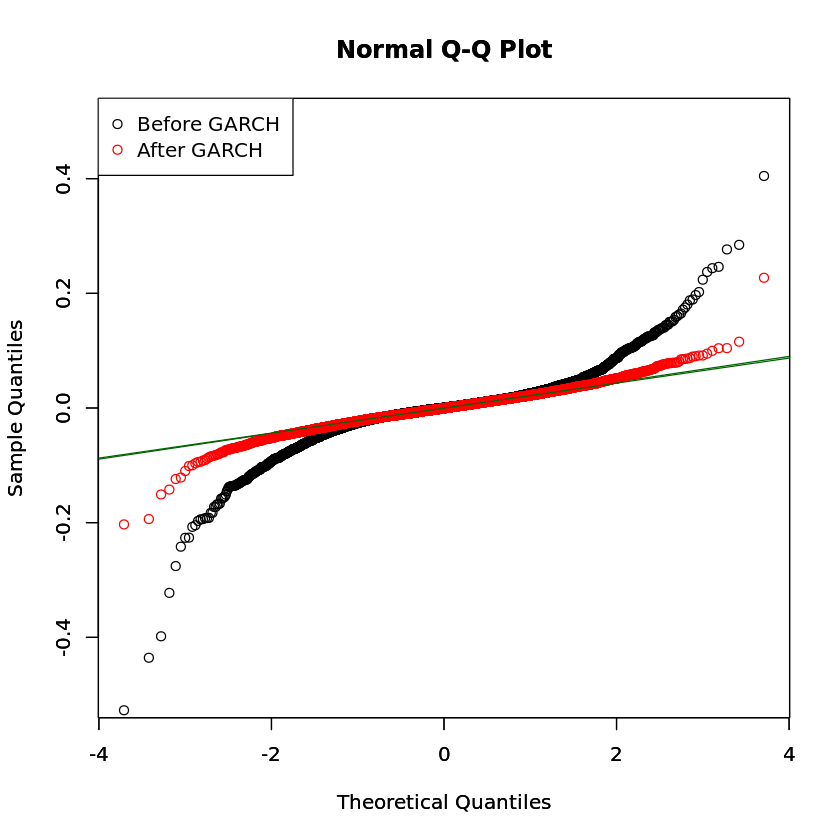

In [48]:
# Define the data to plot: the 1-year maturity yield changes and residuals 
data_orig <- x_1
data_res <- res_1

# Define the benchmark distribution
distribution <- qnorm

# Make the Q-Q plot of original data with the line of normal distribution
qqnorm(data_orig, ylim = c(-0.5, 0.5))
qqline(data_orig, distribution = distribution, col = "darkgreen")

# Make the Q-Q plot of GARCH residuals with the line of normal distribution
par(new=TRUE)
qqnorm(data_res * 0.614256270265139, col = "red", ylim = c(-0.5, 0.5))
qqline(data_res * 0.614256270265139, distribution = distribution, col = "darkgreen")

 #Legend 
legend("topleft", legend = c("Before GARCH", "After GARCH"), col = c("black", "red"), pch = c(1, 1))

In [ ]:
# Define plot data: the 1-year maturity yield changes and the residuals 
soln_data_orig <- x_1
soln_data_res <- res_1

# Define the benchmark distribution (qnorm)
soln_distribution <- qnorm


run_tests({
    test_that("the data_orig is correct", {
        expect_equal(data_orig, soln_data_orig, 
            info = "The data_orig is not correct. Is it equal to the original series of 1-year yield changes?"
        )
    })
    
    test_that("the distribution is correct", {
        expect_equal(distribution, soln_distribution, 
            info = "The distribution is not correct. Is it based on the normal distribution?"
        )
    })
    
    test_that("the data_res is correct", {
        expect_equal(data_res, soln_data_res, 
            info = "The data_res is not correct. Is it equal to the residuals of the model fitted on 1-year yield changes?"
        )
    })
})
    

## 10. A final quiz
<p>In this project, we fitted a GARCH model to develop a better understanding of how bond volatility evolves and how it affects the probability distribution. In the final task, we will evaluate our model. Did the model succeed, or did it fail?</p>

In [ ]:
# Q1: Did GARCH revealed how volatility changed over time? # Yes or No?
(Q1 <- "Yes")

# Q2: Did GARCH bring the residuals closer to normal distribution? Yes or No?
(Q2 <- "Yes")

# Q3: Which time series of yield changes deviates more 
# from a normally distributed white noise process? Choose 1 or 20.
(Q3 <- 1)

In [ ]:
run_tests({
    test_that("the Q1 is correct", {
        expect_equal(tolower(Q1), "yes", 
            info = "The 1st answer is not correct. If GARCH could not estimate the volatility over time, its plot would be a constant line."
        )
    })
    
    test_that("the Q2 is correct", {
        expect_equal(tolower(Q2), "yes", 
            info = "The 2nd answer is not correct. The residuals from the examples are still not normal, but they are less erratic than before."
        )
    })
    
    test_that("the Q3 is correct", {
        expect_equal(Q3, 1, 
            info = "The 3rd answer is not correct. Which time series showed rapid changes in behavior?"
        )
    })
})